In [1]:
#https://www.eeoc.gov/statistics/employment/jobpatterns/eeo1

import pandas as pd
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas.plotting import table

column_mapping_file = "ColumnHeaderInformation.csv"
EE01_dataset = "DiversityDataset.csv"
column_aggregate_all = 'TOTAL10'
Comparisions = ["NAICS2_Name", "Region", "State"]
str_columns = ['Nation', 'Region', 'Division', 'State', 'CBSA','County', 'NAICS2_Name',
                'NAICS3_Name']
industry_name="NAICS2_Name"
Comparisions_Types = ['Race', 'Sex', 'Job']

def getColumnMappingDict():
    input_file = csv.DictReader(open(column_mapping_file))
    column_mapping = {}
    for row in input_file:
        column_label_split = row['Column Label'].split(",")
        column_label = {}
        for label in column_label_split:
            label_split = label.split(":")
            column_label[label_split[0].strip()]=label_split[1].strip()
        column_mapping[row['Column Name'].strip()]=column_label
    return column_mapping

def getColumnHeadersWithParticularLabel(column_mapping, label_race, label_sex, label_job):
    column_headers = set()
    for key,value in column_mapping.items():
        if label_race!='' and label_sex!='' and label_job !='' :
            if value['Race'] == label_race and value['Sex']==label_sex and value['Job']==label_job :
                column_headers.add(key)
        elif label_race =='' and label_sex!='' and label_job !='':
            if value['Race'] != 'Aggregate' and value['Sex']==label_sex and value['Job']==label_job:
                column_headers.add(key)
        elif label_race !='' and label_sex =='' and label_job !='':
            if value['Race'] == label_race and value['Sex']!='Aggregate' and value['Job']==label_job:
                column_headers.add(key)
        elif label_race !='' and label_sex !='' and label_job =='':
            if value['Race'] == label_race and value['Sex']==label_sex and value['Job']!='Aggregate':
                column_headers.add(key)
        else:
            print('Wrong Input')
    return list(column_headers)

def getDataFrameFromCSV(file_name):
    df = pd.read_csv(EE01_dataset, encoding = "ISO-8859-1", engine='python')
    df.columns = df.columns.str.strip()
    column_list = list(df.columns)
    int_columns = [x for x in column_list if x not in str_columns]
    df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce').fillna(0)
    return df

def getRelevantColumns(df, column_list):
    print("Using Columns from EE01 Dataset - ", column_list)
    df = df[column_list]
    return df

def plotBarChartForADataFrame(df, col_name_x, col_name_y, title, yLabel, xLabel):
    df=df.set_index(col_name_x)
    number_of_colors = 20
    mycolors = ["#"+''.join([random.choice('0123456789ABCDE') for j in range(6)])
             for i in range(number_of_colors)]
    #mycolors = ["r", "hotpink", "g", "b","c","m","y","#DC143C","#8A2BE2","#A52A2A","#FF7F50","#00FFFF","k","#00008B","#8B008B","#FFFF00","#DB7093","#4B0082","#FF4500","#DAA520"]
    plt.figure()
    plt.title(title,fontsize=14,fontweight='bold')
    ax = plt.gca()
    ax.tick_params(axis='x', size=14)
    ax.tick_params(axis='y', size=14)
    #labels = ax.get_xticklabels() + ax.get_yticklabels()
    #[label.set_fontweight('bold') for label in labels]
    df[col_name_y].plot(
                    kind="bar",
                   figsize=(12, 5),
                   color=mycolors)
    plt.ylabel(yLabel,color="purple",fontsize=14,fontweight='bold')
    plt.xlabel(xLabel,color="purple",fontsize=14,fontweight='bold')

def defineDataset(column_mapping):
    set_race = set()
    set_sex = set()
    set_job = set()
    for key,value in column_mapping.items():
        set_race.add(value['Race'])
        set_sex.add(value['Sex'])
        set_job.add(value['Job'])
    return list(set_race), list(set_sex), list(set_job)

def plotLineGraphForADataFrame(df, column_grouped_by, column_headers,title, yLabel, xLabel):
    y_axis = column_headers.remove(column_grouped_by)
    df.plot(x=column_grouped_by, y=y_axis,figsize=(15, 5))
    df=df.set_index(column_grouped_by)
    plt.title(title,fontsize=14,fontweight='bold')
    plt.xticks(range(0,len(df.index)),df.index,rotation=90)
    plt.ylabel(yLabel,color="purple",fontsize=14,fontweight='bold')
    plt.xlabel(xLabel,color="purple",fontsize=14,fontweight='bold')
    plt.show()
    
def DrawComparisionBetweenColumnsForADataFrame(df, column_headers, column_grouped_by, title):
    df=df.groupby(column_grouped_by, as_index=False)[column_headers].sum()
    shape = df.shape
    columns_list = list(df.columns)
    if(shape[1]==2):
        plotBarChartForADataFrame(df, columns_list[0], columns_list[1], title,"Percentages (%)","Industries")
    else:
        plotLineGraphForADataFrame(df, column_grouped_by, column_headers,title,"Percentages (%)","Industries")

def renameDataFrameMapping(df, column_mapping, mapping_to_take):
    column_list = df.columns
    new_column_list = []
    rename_mapping = {}
    for column in column_list:
        if column in column_mapping:
            rename_mapping[column]=column_mapping[column][mapping_to_take]
            new_column_list.append(column_mapping[column][mapping_to_take])
        else:
            rename_mapping[column]=column
            new_column_list.append(column)
    df=df.rename(columns = rename_mapping)
    return df,new_column_list

def industryWiseComparison(label):
    if label=='Race':
        getFunctionsForComparison('','Aggregate','Aggregate','Race','Industry wise - Race comparision')
    elif label=='Sex':
        getFunctionsForComparison('Aggregate','','Aggregate','Sex','Industry wise - Sex comparision')
    elif label=='Job Profile':
        getFunctionsForComparison('Aggregate','Aggregate','','Job','Industry wise - Job Profile comparision')
    
def getFunctionsForComparison(label_race,label_sex,label_job,mapping_to_take,title):
    column_headers = getColumnHeadersWithParticularLabel(column_mapping, label_race, label_sex, label_job)
    column_headers.append(industry_name)
    df = getRelevantColumns(EE01_df, column_headers)
    df,column_headers = renameDataFrameMapping(df, column_mapping, mapping_to_take)
    DrawComparisionBetweenColumnsForADataFrame(df, column_headers, industry_name, title)

In [2]:
column_mapping = getColumnMappingDict()
EE01_df = getDataFrameFromCSV(EE01_dataset)

Using Columns from EE01 Dataset -  ['TOTAL10', 'NAICS2_Name']


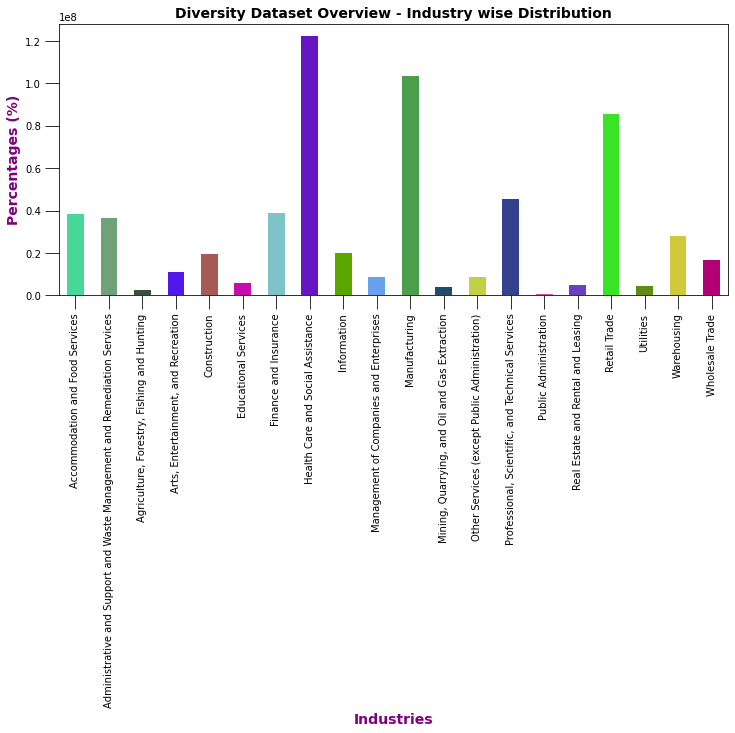

In [3]:
# Step 1 : Industry wise - Aggregate comparision
column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', 'Aggregate', 'Aggregate')
column_headers.append(industry_name)
df = getRelevantColumns(EE01_df, column_headers)
DrawComparisionBetweenColumnsForADataFrame(df, column_headers, industry_name, 'Diversity Dataset Overview - Industry wise Distribution')

Using Columns from EE01 Dataset -  ['NHOPIT10', 'AIANT10', 'ASIANT10', 'HISPT10', 'WHT10', 'BLKT10', 'TOMRT10', 'NAICS2_Name']


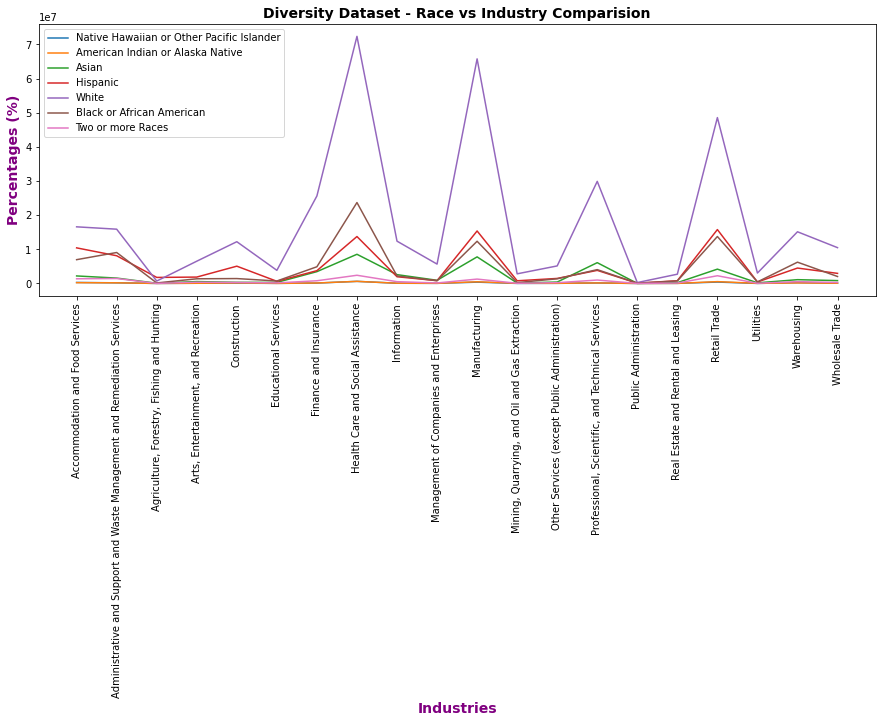

Using Columns from EE01 Dataset -  ['FT10', 'MT10', 'NAICS2_Name']


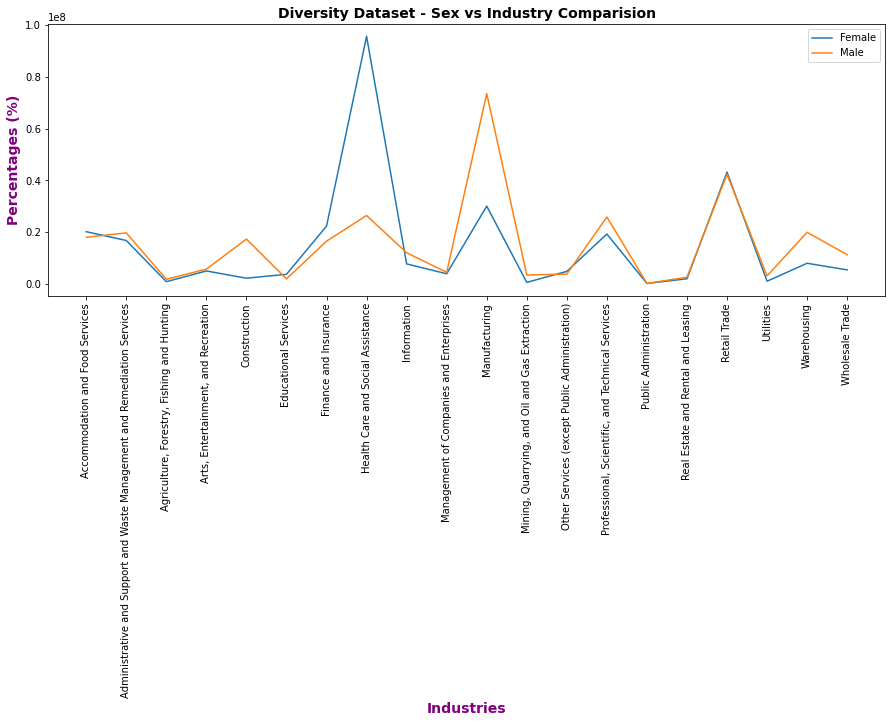

Using Columns from EE01 Dataset -  ['TOTAL1', 'TOTAL3', 'TOTAL6', 'TOTAL1_2', 'TOTAL5', 'TOTAL2', 'TOTAL7', 'TOTAL4', 'TOTAL8', 'TOTAL9', 'NAICS2_Name']


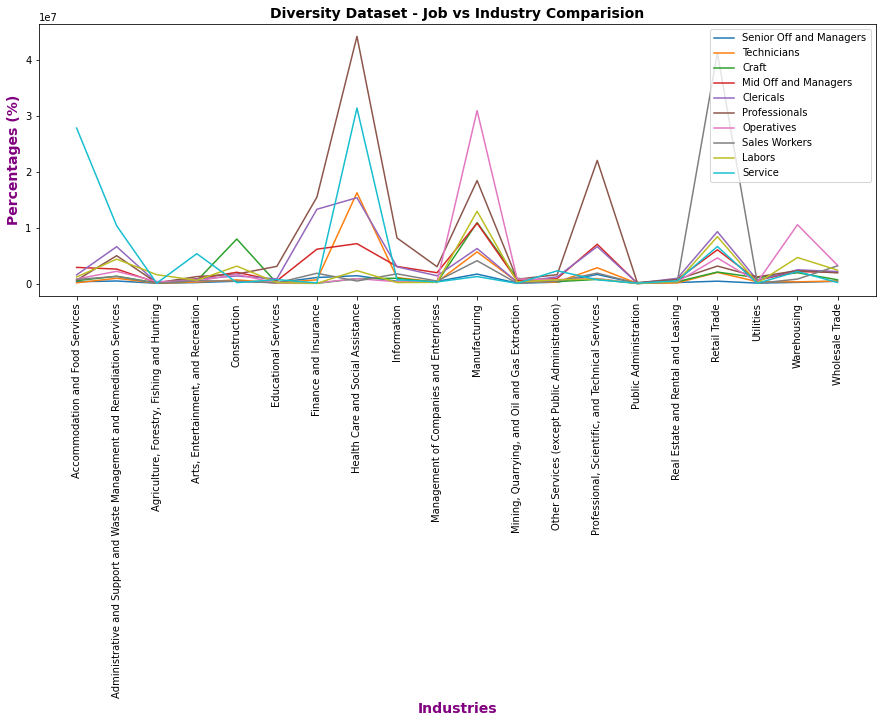

Using Columns from EE01 Dataset -  ['NHOPIT10', 'AIANT10', 'ASIANT10', 'HISPT10', 'WHT10', 'BLKT10', 'TOMRT10', 'Region']


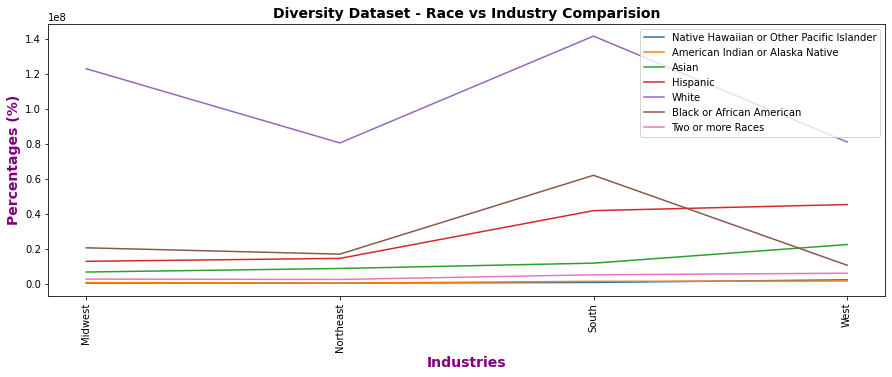

Using Columns from EE01 Dataset -  ['FT10', 'MT10', 'Region']


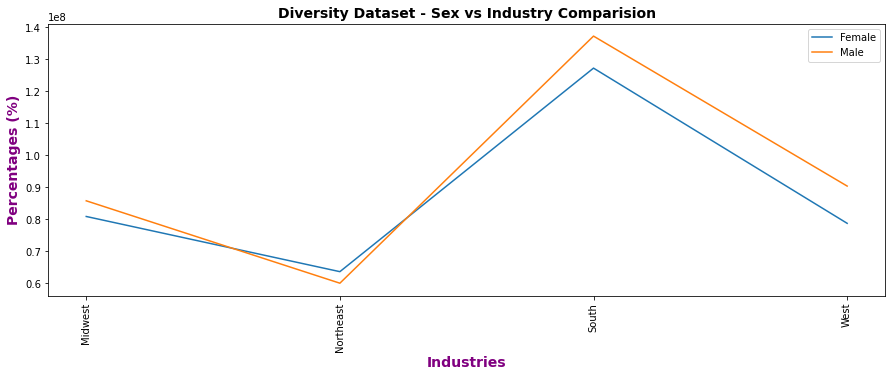

Using Columns from EE01 Dataset -  ['TOTAL1', 'TOTAL3', 'TOTAL6', 'TOTAL1_2', 'TOTAL5', 'TOTAL2', 'TOTAL7', 'TOTAL4', 'TOTAL8', 'TOTAL9', 'Region']


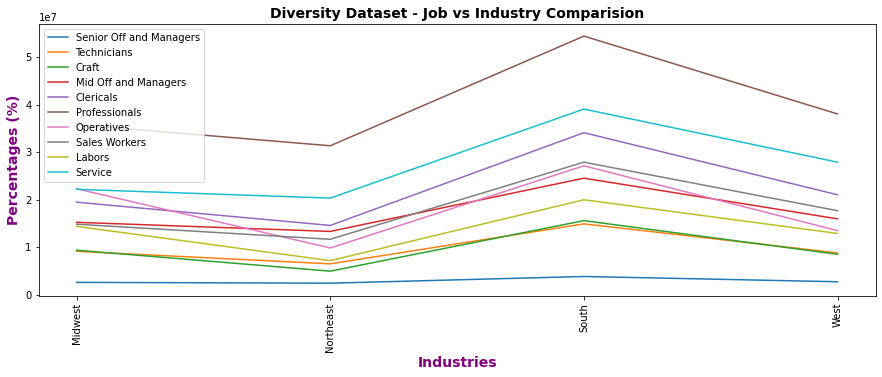

Using Columns from EE01 Dataset -  ['NHOPIT10', 'AIANT10', 'ASIANT10', 'HISPT10', 'WHT10', 'BLKT10', 'TOMRT10', 'State']


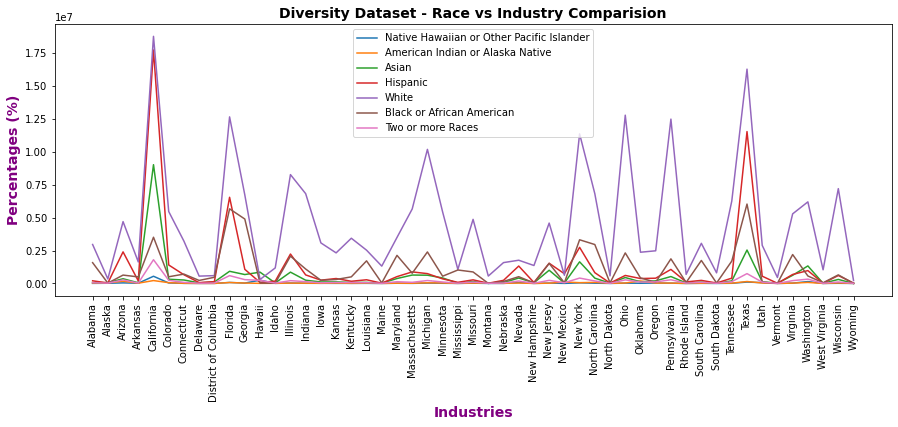

Using Columns from EE01 Dataset -  ['FT10', 'MT10', 'State']


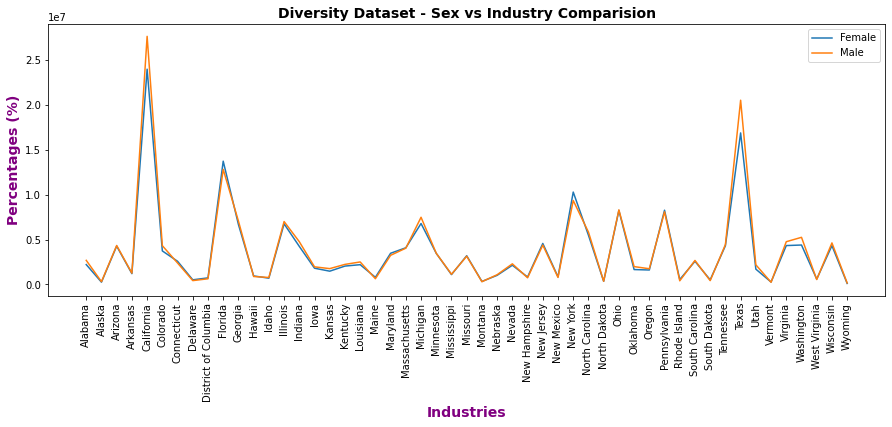

Using Columns from EE01 Dataset -  ['TOTAL1', 'TOTAL3', 'TOTAL6', 'TOTAL1_2', 'TOTAL5', 'TOTAL2', 'TOTAL7', 'TOTAL4', 'TOTAL8', 'TOTAL9', 'State']


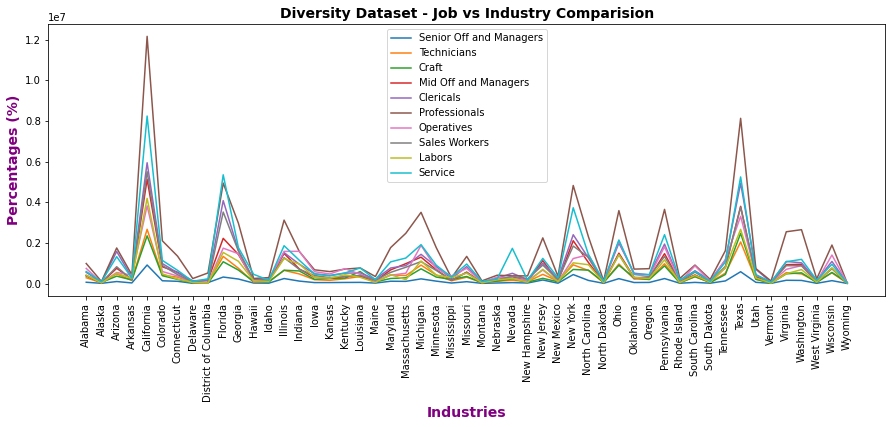

In [4]:
#Step 2 : Industry wise/State wise/Region wise - Race, Sex and Job profile Comparison
for column_comparision_wise in Comparisions:
    for comparision_element in Comparisions_Types:
        if(comparision_element=='Race'):
            column_headers = getColumnHeadersWithParticularLabel(column_mapping, '', 'Aggregate', 'Aggregate')
        elif(comparision_element=='Sex'):
            column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', '', 'Aggregate')
        else:
            column_headers = getColumnHeadersWithParticularLabel(column_mapping, 'Aggregate', 'Aggregate', '')        

        column_headers.append(column_comparision_wise)
        df = getRelevantColumns(EE01_df, column_headers)
        df,column_headers = renameDataFrameMapping(df, column_mapping, comparision_element)
        DrawComparisionBetweenColumnsForADataFrame(df, column_headers, column_comparision_wise, 'Diversity Dataset - '+comparision_element+' vs Industry Comparision')
        mean_table=df[column_headers].mean()